# Experiment 9b (3-layer ANN) - Train ANN until model achieves 90% accuracy (on practiced tasks only)

In [19]:
import numpy as np
import torch
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from model import analysis
from model import task
from importlib import reload
import tools
import pandas as pd
analysis = reload(analysis)
sns.set_style("whitegrid")

In [20]:
datadir = '../../data/model_results/experiment9/'
palette = sns.color_palette("Set2")


#### Sample commands for 3 networks
`python experiment9_3layers.py --acc_cutoff 90 --nepochs 0 --pretraining --practice --cuda --verbose --nsimulations 40`

`python experiment9_3layers.py --acc_cutoff 90 --nepochs 0 --rule2pretraining --practice --cuda --verbose --nsimulations 40`

`python experiment9_3layers.py --acc_cutoff 90 --nepochs 0 --practice --cuda --verbose --nsimulations 40`

# Load data and format dataframes

In [22]:
simstart = 0
simend = 40

#
df_adam = pd.DataFrame()
#
df_adam_1rule = pd.DataFrame()
#
df_adam_nopretraining = pd.DataFrame()

for i in range(simstart,simend):
    #
    tmp = pd.read_csv(datadir + 'expt9_adam_90accCutOff_3layers_2rulepretraining_practice_simData' + str(i) + '.csv')
    tmp.insert(len(tmp.columns),"Simulation",list(np.repeat(i,len(tmp))),True)
    tmp.insert(len(tmp.columns),"Training",list(np.repeat('Simple task pretraining',len(tmp))),True)
    df_adam = df_adam.append(tmp)
    #
    tmp = pd.read_csv(datadir + 'expt9_adam_90accCutOff_3layers_pretraining_practice_simData' + str(i) + '.csv')
    tmp.insert(len(tmp.columns),"Simulation",list(np.repeat(i,len(tmp))),True)
    tmp.insert(len(tmp.columns),"Training",list(np.repeat('Concept pretraining',len(tmp))),True)
    df_adam_1rule = df_adam_1rule.append(tmp)
    #
    tmp = pd.read_csv(datadir + 'expt9_adam_90accCutOff_3layers_practice_simData' + str(i) + '.csv')
    tmp.insert(len(tmp.columns),"Simulation",list(np.repeat(i,len(tmp))),True)
    tmp.insert(len(tmp.columns),"Training",list(np.repeat('Vanilla',len(tmp))),True)
    df_adam_nopretraining = df_adam_nopretraining.append(tmp)
    
    # Include zero-shot dataframes
    tmp = pd.read_csv(datadir + 'expt9_adam_zeroshot_3layers_2rulepretraining_simData' + str(i) + '.csv')
    tmp.insert(len(tmp.columns),"Simulation",list(np.repeat(i,len(tmp))),True)
    tmp.insert(len(tmp.columns),"Training",list(np.repeat('Simple task pretraining',len(tmp))),True)
    df_adam = df_adam.append(tmp)
    #
    tmp = pd.read_csv(datadir + 'expt9_adam_zeroshot_3layers_pretraining_simData' + str(i) + '.csv')
    tmp.insert(len(tmp.columns),"Simulation",list(np.repeat(i,len(tmp))),True)
    tmp.insert(len(tmp.columns),"Training",list(np.repeat('Concept pretraining',len(tmp))),True)
    df_adam_1rule = df_adam_1rule.append(tmp)
    #
    tmp = pd.read_csv(datadir + 'expt9_adam_zeroshot_3layers_simData' + str(i) + '.csv')
    tmp.insert(len(tmp.columns),"Simulation",list(np.repeat(i,len(tmp))),True)
    tmp.insert(len(tmp.columns),"Training",list(np.repeat('Vanilla',len(tmp))),True)
    df_adam_nopretraining = df_adam_nopretraining.append(tmp)
    
df_all = pd.concat([df_adam_nopretraining,
                    df_adam_1rule,
                    df_adam])

# Transform accuracies to out of 100%
df_all.Accuracy = df_all.Accuracy.values * 100.0

##########
# Calculate total number of training samples/trials per simulation
df_all['TotalTrials'] = df_all[['NumPretrainingTrials', 'NumActualTrials']].sum(axis=1)

##########
# Calculate average PS scores
df_all['PS1'] = df_all[['LogicPS1', 'SensoryPS1', 'MotorPS1']].mean(axis=1)
df_all['PS2'] = df_all[['LogicPS2', 'SensoryPS2', 'MotorPS2']].mean(axis=1)
df_all['PS3'] = df_all[['LogicPS3', 'SensoryPS3', 'MotorPS3']].mean(axis=1)
df_all['PSavg'] = df_all[['PS1', 'PS2','PS3']].mean(axis=1)


## Accuracy vs. NumPracticedTasks

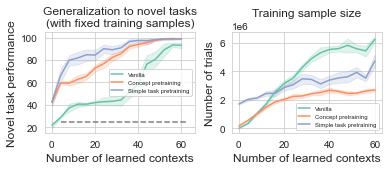

In [23]:
# prac_acc = df.loc[df['Condition']=='Practiced']
# rule2_acc = df.loc[df['Condition']=='2-rule overlap']
# rule1_acc = df.loc[df['Condition']=='1-rule overlap']
plt.figure(figsize=(5.5,2.5))
plt.subplot(1,2,1)
sns.lineplot(x="NumPracticedTasks",y="Accuracy",hue="Training",data=df_all,palette="Set2")
plt.plot(np.arange(4,64),np.repeat(25,len(np.arange(4,64))),'gray',linestyle='--')
# plt.plot(np.arange(4,64),np.repeat(.80,len(np.arange(4,64))),'r',linestyle='--',label='Training cut-off on practice')
plt.title('Generalization to novel tasks\n(with fixed training samples)', fontsize=12)
plt.xlabel('Number of learned contexts', fontsize=12)
plt.ylabel('Novel task performance', fontsize=12)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10);
plt.ylim([15,105])
plt.legend(fontsize=6)

plt.subplot(1,2,2)
sns.lineplot(x="NumPracticedTasks",y="TotalTrials",hue="Training",data=df_all,palette="Set2")
# plt.plot(np.arange(4,64),np.repeat(.80,len(np.arange(4,64))),'r',linestyle='--',label='Training cut-off on practice')
plt.title('Training sample size', fontsize=12,y=1.1)
plt.xlabel('Number of learned contexts', fontsize=12)
plt.ylabel('Number of trials', fontsize=12)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10);
plt.legend(fontsize=6)
plt.tight_layout()
# plt.savefig('Expt9b_90accCutOff.png',dpi=300)

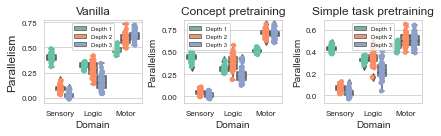

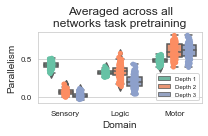

In [24]:
df_ps_2rule = {}
df_ps_2rule['Depth'] = []
df_ps_2rule['Parallelism'] = []
df_ps_2rule['Domain'] = []
df_ps_2rule['Simulation'] = []

df_ps_1rule = {}
df_ps_1rule['Depth'] = []
df_ps_1rule['Parallelism'] = []
df_ps_1rule['Domain'] = []
df_ps_1rule['Simulation'] = []

df_ps_vanilla = {}
df_ps_vanilla['Depth'] = []
df_ps_vanilla['Parallelism'] = []
df_ps_vanilla['Domain'] = []
df_ps_vanilla['Simulation'] = []

for i in range(simstart,simend):
    # Concept pretraining
    tmpdf = df_adam_1rule.loc[df_adam_1rule.Simulation==i]
    tmpdf = tmpdf.loc[tmpdf.NumPracticedTasks==60]
    for depth in range(1,4):
        for rule in ['Sensory','Logic','Motor']:
            df_ps_2rule['Simulation'].append(i)
            df_ps_2rule['Depth'].append('Depth ' + str(depth))
            df_ps_2rule['Domain'].append(rule)
            df_ps_2rule['Parallelism'].append(tmpdf[rule + 'PS' + str(depth)].values[0])

    # Simple task 
    tmpdf = df_adam.loc[df_adam.Simulation==i]
    tmpdf = tmpdf.loc[tmpdf.NumPracticedTasks==60]
    for depth in range(1,4):
        for rule in ['Sensory','Logic','Motor']:
            df_ps_1rule['Simulation'].append(i)
            df_ps_1rule['Depth'].append('Depth ' + str(depth))
            df_ps_1rule['Domain'].append(rule)
            df_ps_1rule['Parallelism'].append(tmpdf[rule + 'PS' + str(depth)].values[0])
            
    # Vanilla 
    tmpdf = df_adam_nopretraining.loc[df_adam_nopretraining.Simulation==i]
    tmpdf = tmpdf.loc[tmpdf.NumPracticedTasks==60]
    for depth in range(1,4):
        for rule in ['Sensory','Logic','Motor']:
            df_ps_vanilla['Simulation'].append(i)
            df_ps_vanilla['Depth'].append('Depth ' + str(depth))
            df_ps_vanilla['Domain'].append(rule)
            df_ps_vanilla['Parallelism'].append(tmpdf[rule + 'PS' + str(depth)].values[0])

df_ps_2rule = pd.DataFrame(df_ps_2rule)
df_ps_1rule = pd.DataFrame(df_ps_1rule)
df_ps_vanilla = pd.DataFrame(df_ps_vanilla)

plt.figure(figsize=(6,2))
plt.subplot(131)
ax = sns.boxplot(x="Domain",y="Parallelism",hue="Depth",palette='Set2',data=df_ps_vanilla)
sns.stripplot(x="Domain",y="Parallelism",hue="Depth",palette='Set2',dodge=True,data=df_ps_vanilla)
plt.title('Vanilla', fontsize=12)
# plt.xlabel(fontsize=12)
plt.ylabel('Parallelism', fontsize=12)
plt.xticks(fontsize=8);
plt.yticks(fontsize=8);
plt.legend()
handles, labels = ax.get_legend_handles_labels()
# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:3], labels[0:3],fontsize=6)
# plt.ylim([0,.5])

plt.subplot(132)
ax = sns.boxplot(x="Domain",y="Parallelism",hue="Depth",palette='Set2',data=df_ps_1rule)
sns.stripplot(x="Domain",y="Parallelism",hue="Depth",palette='Set2',dodge=True,data=df_ps_1rule)
plt.title('Concept pretraining', fontsize=12)
# plt.xlabel(fontsize=12)
# plt.ylabel('Parallelism', fontsize=12)
plt.xticks(fontsize=8);
plt.yticks(fontsize=8);
plt.legend()
handles, labels = ax.get_legend_handles_labels()
# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:3], labels[0:3],fontsize=6)
# plt.ylim([0,.5])

plt.subplot(133)
ax = sns.boxplot(x="Domain",y="Parallelism",hue="Depth",palette='Set2',data=df_ps_2rule)
sns.stripplot(x="Domain",y="Parallelism",hue="Depth",palette='Set2',dodge=True,data=df_ps_2rule)
plt.title('Simple task pretraining', fontsize=12)
# plt.xlabel(fontsize=12)
# plt.ylabel('Parallelism', fontsize=12)
plt.xticks(fontsize=8);
plt.yticks(fontsize=8);
plt.legend()
handles, labels = ax.get_legend_handles_labels()
# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:3], labels[0:3],fontsize=6)
# plt.ylim([0,.5])
plt.tight_layout()


## Average?
tmpdf_avgall = pd.concat([df_ps_2rule, df_ps_1rule, df_ps_vanilla])
plt.figure(figsize=(3,2))
ax = sns.boxplot(x="Domain",y="Parallelism",hue="Depth",palette='Set2',data=tmpdf_avgall)
sns.stripplot(x="Domain",y="Parallelism",hue="Depth",palette='Set2',dodge=True,data=tmpdf_avgall)
plt.title('Averaged across all\nnetworks task pretraining', fontsize=12)
# plt.xlabel(fontsize=12)
# plt.ylabel('Parallelism', fontsize=12)
plt.xticks(fontsize=8);
plt.yticks(fontsize=8);
plt.legend()
handles, labels = ax.get_legend_handles_labels()
# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:3], labels[0:3],fontsize=6)
# plt.ylim([0,.5])
plt.tight_layout()

# plt.tight_layout()
# # plt.savefig('Experiment9b_PSvDepth.png', dpi=300)